In [113]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp,fmin,tpe, Trials
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn import preprocessing
from sklearn import model_selection

%matplotlib inline
plt.style.use('seaborn')

In [114]:
data = pd.read_csv('data/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

In [115]:
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [117]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


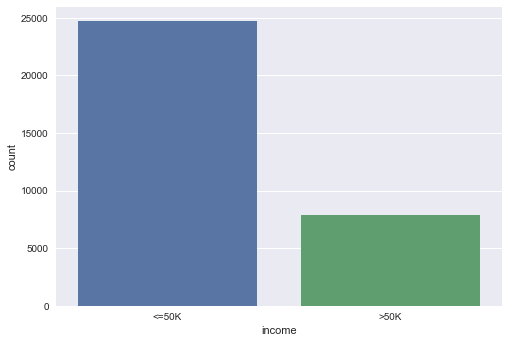

In [118]:
sns.countplot(data = data, x = 'income');

In [119]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [120]:
cat_features = list(data.select_dtypes(include = 'object').columns)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

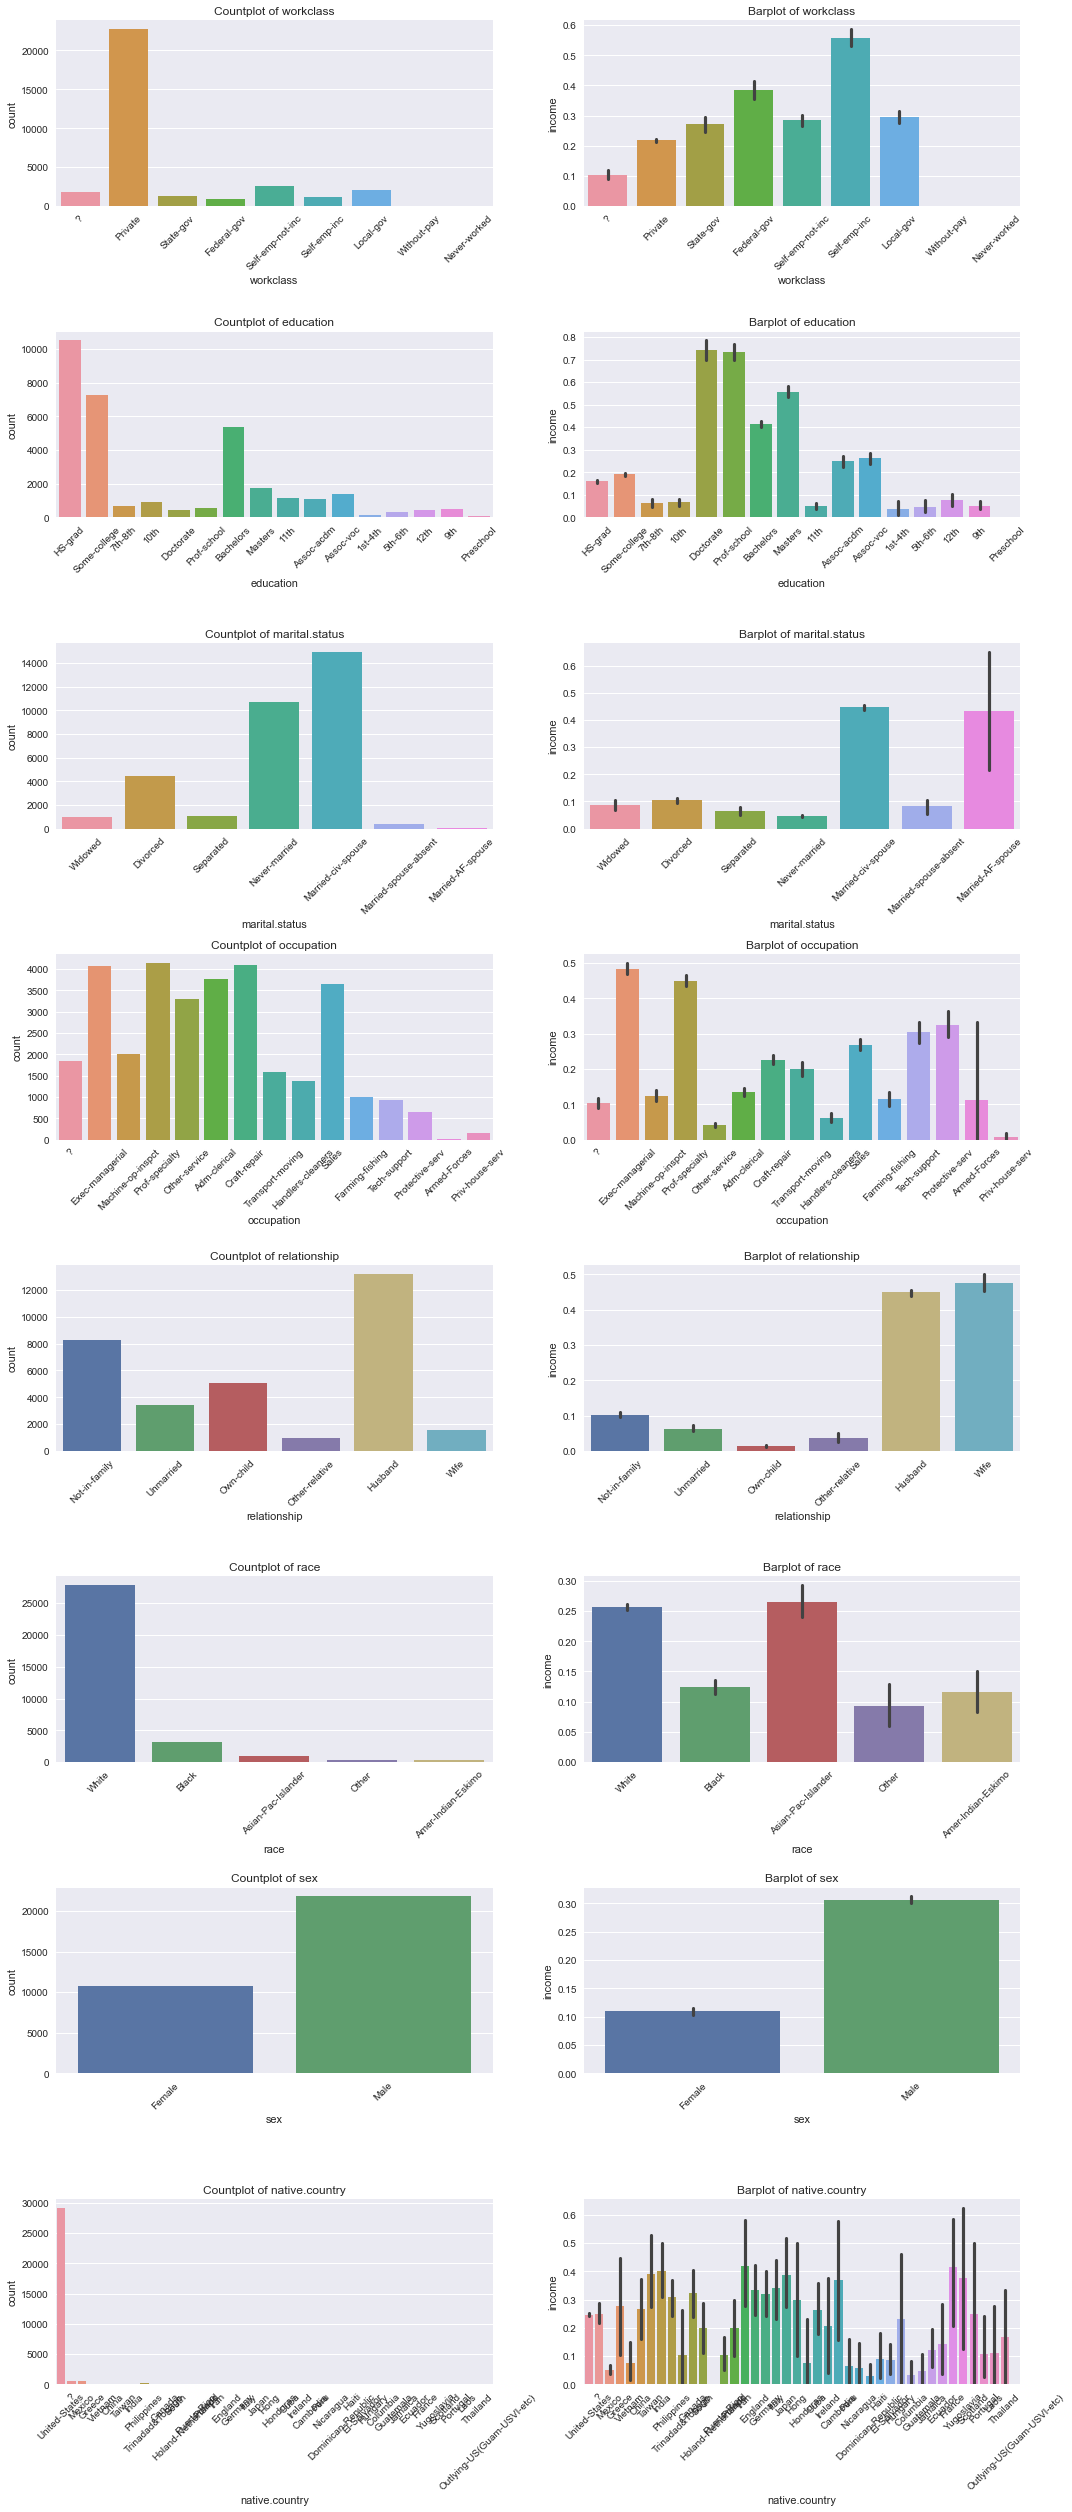

In [121]:
n = len(cat_features)
fig, axes = plt.subplots(n, 2, figsize = (15,35))
for i, feature in enumerate(cat_features):
    countplot = sns.countplot(data = data, x = feature, ax = axes[i][0])
    countplot.set_title(f'Countplot of {feature}')
    countplot.xaxis.set_tick_params(rotation = 45)
    barplot = sns.barplot(data = data, x = feature, y = 'income', ax = axes[i][1])
    barplot.set_title(f'Barplot of {feature}')
    barplot.xaxis.set_tick_params(rotation = 45)
plt.tight_layout()
    

Предобработка данных

In [122]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

In [123]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [124]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

In [125]:
adult_data.describe(include='object')
cat_cols = list(adult_data.select_dtypes(include = 'object').columns)

<AxesSubplot:>

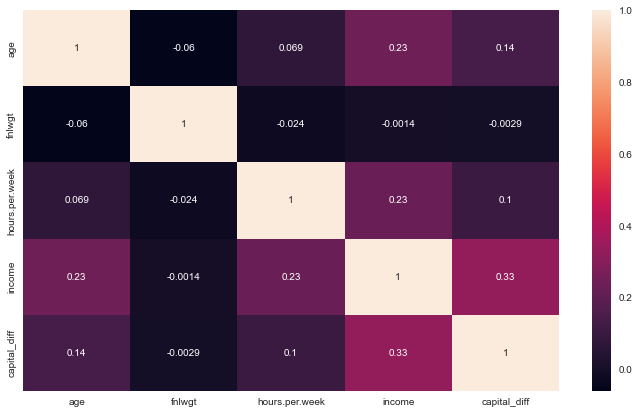

In [126]:
plt.figure(figsize= (12,7))
sns.heatmap(adult_data.corr(), annot= True)

### Using One Hot Encoding

In [127]:
# OneHotEncoder = preprocessing.OneHotEncoder()
# onehot_data = OneHotEncoder.fit_transform(adult_data[cat_cols]).toarray().astype('int')
# columns = OneHotEncoder.get_feature_names_out(cat_cols)
# onehot_data_df = pd.DataFrame(data= onehot_data, columns= columns)
# onehot_data_df.head()
# data_new = pd.concat([adult_data, onehot_data_df], axis = 1)
# data_new.drop(columns= cat_cols, inplace= True)


In [128]:
dummies_data = pd.get_dummies(data= adult_data, drop_first=True)
dummies_data.head()
dummies_data.columns

Index(['age', 'fnlwgt', 'hours.per.week', 'income', 'capital_diff',
       'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_No income',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Preschool', 'education_Prof-school',
       'education_School', 'education_Some-college',
       'marital.status_Never-married', 'marital.status_Prev-Married',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationsh

In [129]:
X = dummies_data.drop(['income'], axis = 1)
y = dummies_data['income']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size= 0.2, random_state= 1)

In [131]:
MMScaler = preprocessing.MinMaxScaler()
MMScaler.fit(X_train)
X_train_scaled = MMScaler.transform(X_train)
X_test_scaled = MMScaler.transform(X_test)

In [134]:
log_reg = linear_model.LogisticRegression(max_iter= 1000, random_state= 42)
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)
print('Accuracy on our test selection {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('f1 score on our test selection {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Accuracy on our test selection 0.84
f1 score on our test selection 0.64


In [ ]:
print(f'Версия Hyperoft {hyperopt.__version__}')

Версия Hyperoft 0.2.5


In [135]:
# зададим пространство поиска гиперпараметров
space = {'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [136]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [139]:
# начинаем подбор гиперпараметров
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))


100%|██████████| 20/20 [00:41<00:00,  2.09s/trial, best loss: -0.7986892215038526]
Наилучшее значение гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}
CPU times: user 41.5 s, sys: 258 ms, total: 41.8 s
Wall time: 42 s


In [140]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state= random_state,
    n_estimators= int(best['n_estimators']),
    max_depth= int(best['max_depth']),
    min_samples_leaf= int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


f1_score на обучающем наборе: 0.80
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


In [141]:
# начинаем подбор гиперпараметров
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))


100%|██████████| 23/23 [00:05<00:00,  1.73s/trial, best loss: -0.7986892215038526]
Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}


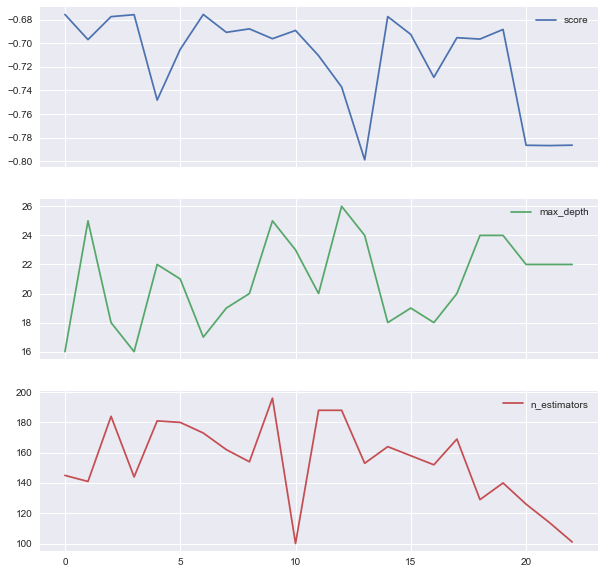

In [142]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

In [ ]:
# зададим пространство поиска гиперпараметров
space = {'n_estimators': hp.quniform(100,301,10),
       'max_depth' : hp.quniform('max_depth', 3, 7, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 15, 40, 1)
      }

In [150]:
# зафксируем random_state
random_state = 42
def hyperopt_rf_task(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [151]:
%%time

trials_task = Trials()

# начинаем подбор гиперпараметров
best=fmin(hyperopt_rf_task, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials_task, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))


100%|██████████| 20/20 [00:41<00:00,  2.08s/trial, best loss: -0.7986892215038526]
Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}
CPU times: user 41.1 s, sys: 308 ms, total: 41.4 s
Wall time: 41.6 s


In [153]:
model = ensemble.RandomForestClassifier(
    n_estimators= int(best['n_estimators']),
    max_depth= int(best['max_depth']),
    min_samples_leaf= int(best['min_samples_leaf']),
    random_state= random_state
)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print('F1-score is {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

F1-score is 0.68
